## 3. visualize and analysis

In [1]:
import argparse
import pandas as pd
import os
import scanpy as sc
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import cv2
import torchvision.transforms as transforms
from utils import Cal_Spatial_Net, Stats_Spatial_Net, _hungarian_match, seed_everything
from train_transformer import train_nano_fov, test_nano_fov
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt
import random
from scipy.optimize import linear_sum_assignment

### 3.1 load processed adata

In [2]:
all_h5ad = sc.read('pdata/process_data_final.h5ad')

/home/dao2/.local/lib/python3.8/site-packages/anndata-0.8.0rc1-py3.8.egg/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
all_h5ad

AnnData object with n_obs × n_vars = 83621 × 980
    obs: 'cell_type', 'niche', 'cx', 'cy', 'cx_g', 'cy_g', 'merge_cell_type', 'leiden', 'cmap', 'gtcmap'
    uns: 'leiden', 'neighbors'
    obsm: 'gene_pred', 'img_pred', 'imgs', 'pred', 'spatial', 'spatial_global'
    layers: 'recon'
    obsp: 'connectivities', 'distances'

In [4]:
genedf = sc.get.obs_df(
        all_h5ad,
        keys=["leiden", 'cmap', 'gtcmap'])

### 3.2 draw spatial for each fov

In [6]:
count = 0
start = 0
aris = []
ids = [
        'fov1', 'fov2', 'fov3', 'fov4', 'fov5',
        'fov6', 'fov7', 'fov8', 'fov9', 'fov10',
        'fov11', 'fov12', 'fov13', 'fov14', 'fov15',
        'fov16', 'fov17', 'fov18', 'fov19', 'fov20'
]
img_names = [
        'F001', 'F002', 'F003', 'F004', 'F005',
        'F006', 'F007', 'F008', 'F009', 'F010',
        'F011', 'F012', 'F013', 'F014', 'F015',
        'F016', 'F017', 'F018', 'F019', 'F020',
]
for id in ids:
    adata = sc.read(os.path.join('../dataset/nanostring', id, 'sampledata.h5ad'))
    start = count
    end = start + adata.shape[0]
    count = count + adata.shape[0]
    
    adata.var_names_make_unique()

    adata.obs['leiden'] = genedf.iloc[start:end]['leiden']
    obs_df = adata.obs.dropna()
    ari = adjusted_rand_score(obs_df['leiden'], obs_df['merge_cell_type'])
    ari = round(ari, 2)

    aris.append(ari)
#     ARI = adjusted_rand_score(obs_df['leiden'], obs_df['merge_cell_type'])
    # adata.obs['cmap'] = genedf.iloc[start:end]['cmap']
    adata.obs['cmap'] = genedf.iloc[start:end]['cmap']
    adata.obs['gtcmap'] = genedf.iloc[start:end]['gtcmap']

    cx, cy = adata.obs['cx'], adata.obs['cy']
    fig = plt.figure(figsize=(9,9))
    plt.axis('off')
    plt.scatter(cx, cy, c=adata.obs['cmap'].tolist(), s=5)
    plt.xlim(0, 5472)
    plt.ylim(3648, 0)
    if not os.path.exists(os.path.join('../results/nano_jupyter', 'pred_fov')):
        os.makedirs(os.path.join('../results/nano_jupyter', 'pred_fov'))
    plt.savefig(os.path.join('../results/nano_jupyter', 'pred_fov', '%s.png'%(id)), bbox_inches='tight')
    plt.savefig(os.path.join('../results/nano_jupyter', 'pred_fov', '%s.pdf'%(id)), bbox_inches='tight')

    fig = plt.figure(figsize=(9,9))
    plt.axis('off')
    plt.scatter(cx, cy, c=adata.obs['gtcmap'].tolist(), s=5)
    # plt.gca().invert_yaxis()
    plt.xlim(0, 5472)
    plt.ylim(3648, 0)
    if not os.path.exists(os.path.join('../results/nano_jupyter', 'gt_fov')):
        os.makedirs(os.path.join('../results/nano_jupyter', 'gt_fov'))
    plt.savefig(os.path.join('../results/nano_jupyter', 'gt_fov', '%s.png'%(id)), bbox_inches='tight')
    plt.savefig(os.path.join('../results/nano_jupyter', 'gt_fov', '%s.pdf'%(id)), bbox_inches='tight')

    plt.close('all')

### 3.3 merge fovs and show the overall spatial images

In [7]:
def merge_fovs(root='pred_fov', save_name='pred.png'):
    n = ['fov1.png', 'fov2.png', 'fov3.png', 'fov4.png',
            'fov5.png', 'fov6.png', 'fov7.png', 'fov8.png',
            'fov9.png', 'fov10.png', 'fov11.png', 'fov12.png',
            'fov13.png', 'fov14.png', 'fov15.png', 'fov16.png',
            'fov17.png', 'fov18.png', 'fov19.png', 'fov20.png',
            ]

    
    im1 = cv2.imread(os.path.join(root, n[0]))
    im2 = cv2.imread(os.path.join(root, n[1]))
    im3 = cv2.imread(os.path.join(root, n[2]))
    im4 = cv2.imread(os.path.join(root, n[3]))
    imrow1 = cv2.hconcat([im1, im2, im3, im4])

    im5 = cv2.imread(os.path.join(root, n[4]))
    im6 = cv2.imread(os.path.join(root, n[5]))
    im7 = cv2.imread(os.path.join(root, n[6]))
    im8 = cv2.imread(os.path.join(root, n[7]))
    imrow2 = cv2.hconcat([im5, im6, im7, im8])

    im9 = cv2.imread(os.path.join(root, n[8]))
    im10 = cv2.imread(os.path.join(root, n[9]))
    im11 = cv2.imread(os.path.join(root, n[10]))
    im12 = cv2.imread(os.path.join(root, n[11]))
    imrow3 = cv2.hconcat([im9, im10, im11, im12])

    im13 = cv2.imread(os.path.join(root, n[12]))
    im14 = cv2.imread(os.path.join(root, n[13]))
    im15 = cv2.imread(os.path.join(root, n[14]))
    im16 = cv2.imread(os.path.join(root, n[15]))
    imrow4 = cv2.hconcat([im13, im14, im15, im16])

    im17 = cv2.imread(os.path.join(root, n[16]))
    im18 = cv2.imread(os.path.join(root, n[17]))
    im19 = cv2.imread(os.path.join(root, n[18]))
    im20 = cv2.imread(os.path.join(root, n[19]))
    imrow5 = cv2.hconcat([im17, im18, im19, im20])

    imall = cv2.vconcat([imrow5, imrow4, imrow3, imrow2, imrow1])
    cv2.imwrite(save_name, imall)

In [13]:
def merge_fovs_pdf(root='pred_fov', save_name='pred.png', title='scGIT'):

    n = [
        ['fov17.png', 'fov18.png', 'fov19.png', 'fov20.png',],
        ['fov13.png', 'fov14.png', 'fov15.png', 'fov16.png',],
        ['fov9.png', 'fov10.png', 'fov11.png', 'fov12.png',],
        ['fov5.png', 'fov6.png', 'fov7.png', 'fov8.png',],
        ['fov1.png', 'fov2.png', 'fov3.png', 'fov4.png',],
    ]

    fig, axs = plt.subplots(5, 4, figsize=(16, 12))
    fig.suptitle(title,fontweight ="bold")

    for i in axs:
        for j in i:
            j.axis('off')

    for i in range(len(n)):
        for j in range(len(n[0])):
            name = n[i][j]
            img = cv2.imread(os.path.join(root, name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axs[i,j].imshow(img)

    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    plt.savefig(save_name)

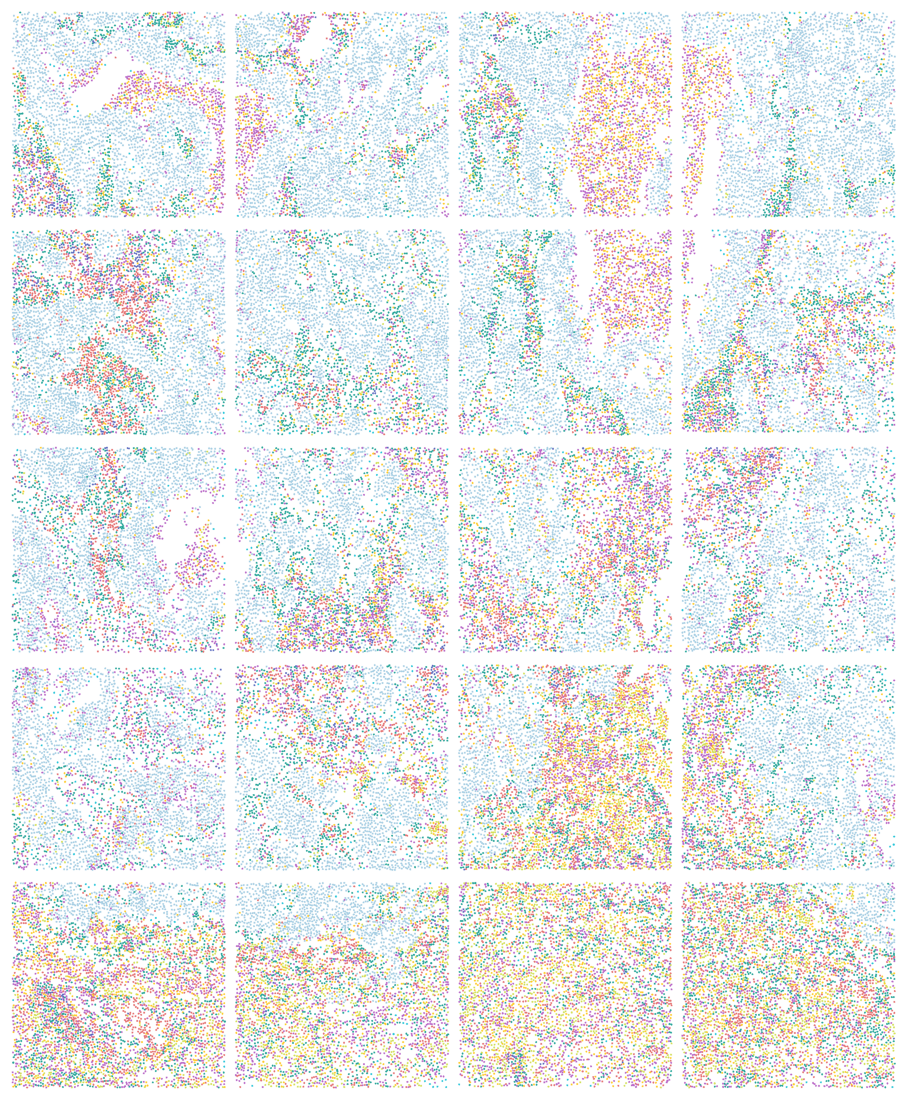

In [8]:
merge_fovs(root='../results/nano_jupyter/pred_fov', save_name='../figures3/pred.png')
merge_fovs(root='../results/nano_jupyter/gt_fov', save_name='../figures3/gt.png')

pred_img = cv2.imread('../figures3/pred.png')
pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
figure = plt.figure(figsize=(25, 20))
plt.imshow(pred_img)
plt.axis('off')
plt.savefig('../figures3/pred.pdf')

### 3.4 denoising

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def draw_spatial(gene_name, vmax=1):
    start = 0
    if not os.path.exists('recon/%s/raw'%(gene_name)):
        os.makedirs('recon/%s/raw'%(gene_name))
    if not os.path.exists('recon/%s/recon'%(gene_name)):
        os.makedirs('recon/%s/recon'%(gene_name))
        
    save_path_raw = 'recon/%s/raw'%(gene_name)
    save_path_recon = 'recon/%s/recon'%(gene_name)
    
    for id, iname in zip(ids, img_names):
        adata = sc.read('../dataset/nanostring/%s/sampledata.h5ad'%(id))
        adata.var_names_make_unique()
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)    
        cx, cy = adata.obs['cx'], adata.obs['cy']
        img = cv2.imread('../dataset/nanostring/%s/CellComposite_%s.jpg'%(id, iname))
        count = adata.shape[0]
        end = start + count
        adata.layers['recon'] = all_h5ad.layers['recon'][start:end, :]
        
        recon = adata.copy()
        recon.X = adata.layers['recon']
        start += count

        rawv = adata[:, gene_name].X
        reconv = recon[:, gene_name].X
        fig = plt.figure(figsize=(20,20))
        ax = plt.gca()

        ax.axis('off')
        sp = ax.scatter(cx, cy, c=rawv, vmax=vmax)
        ax.invert_yaxis()
        plt.savefig(os.path.join(save_path_raw, '%s.png'%(id)), bbox_inches='tight')
        plt.close('all')
        
        fig = plt.figure(figsize=(20,20))
        ax = plt.gca()

        ax.axis('off')
        sp = ax.scatter(cx, cy, c=reconv, vmax=vmax)
        ax.invert_yaxis()
        plt.savefig(os.path.join(save_path_recon, '%s.png'%(id)), bbox_inches='tight')
        plt.close('all')
#         print('median: ', np.median(rawv), np.median(reconv), 'max: ', rawv.max(), reconv.max())
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.axis('off')
    fig.colorbar(sp, cax=cax, ax=ax)
    plt.savefig('colorbar.pdf')
    plt.close('all')

    
def merge_fovs_gene(root='pred_fov', save_name='pred.png'):
    n = ['fov1.png', 'fov2.png', 'fov3.png', 'fov4.png',
            'fov5.png', 'fov6.png', 'fov7.png', 'fov8.png',
            'fov9.png', 'fov10.png', 'fov11.png', 'fov12.png',
            'fov13.png', 'fov14.png', 'fov15.png', 'fov16.png',
            'fov17.png', 'fov18.png', 'fov19.png', 'fov20.png',
            ]
    im1 = cv2.imread(os.path.join(root, n[0]))
    im2 = cv2.imread(os.path.join(root, n[1]))
    im3 = cv2.imread(os.path.join(root, n[2]))
    im4 = cv2.imread(os.path.join(root, n[3]))
    imrow1 = cv2.hconcat([im1, im2, im3, im4])

    im5 = cv2.imread(os.path.join(root, n[4]))
    im6 = cv2.imread(os.path.join(root, n[5]))
    im7 = cv2.imread(os.path.join(root, n[6]))
    im8 = cv2.imread(os.path.join(root, n[7]))
    imrow2 = cv2.hconcat([im5, im6, im7, im8])

    im9 = cv2.imread(os.path.join(root, n[8]))
    im10 = cv2.imread(os.path.join(root, n[9]))
    im11 = cv2.imread(os.path.join(root, n[10]))
    im12 = cv2.imread(os.path.join(root, n[11]))
    imrow3 = cv2.hconcat([im9, im10, im11, im12])

    im13 = cv2.imread(os.path.join(root, n[12]))
    im14 = cv2.imread(os.path.join(root, n[13]))
    im15 = cv2.imread(os.path.join(root, n[14]))
    im16 = cv2.imread(os.path.join(root, n[15]))
    imrow4 = cv2.hconcat([im13, im14, im15, im16])

    im17 = cv2.imread(os.path.join(root, n[16]))
    im18 = cv2.imread(os.path.join(root, n[17]))
    im19 = cv2.imread(os.path.join(root, n[18]))
    im20 = cv2.imread(os.path.join(root, n[19]))
    imrow5 = cv2.hconcat([im17, im18, im19, im20])

    imall = cv2.vconcat([imrow5, imrow4, imrow3, imrow2, imrow1])
    cv2.imwrite(save_name, imall)

In [10]:
marker = 'EPCAM'
draw_spatial(marker, vmax=2)
merge_fovs_gene('recon/%s/raw'%(marker), save_name='recon/raw_%s.png'%(marker))
merge_fovs_gene('recon/%s/recon'%(marker), save_name='recon/recon_%s.png'%(marker))

(-0.5, 4519.5, 5504.5, -0.5)

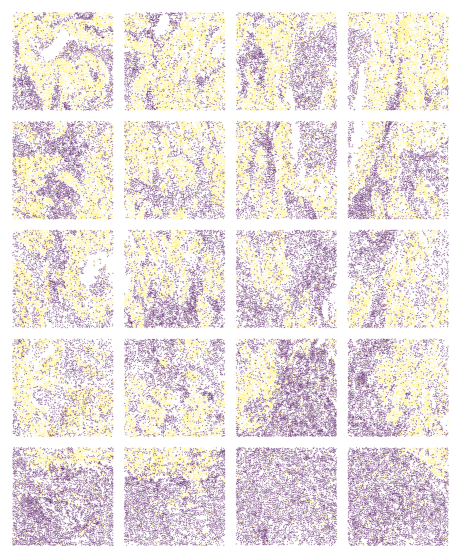

In [11]:
raw_img = cv2.imread('recon/raw_%s.png'%(marker))
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
figure = plt.figure(figsize=(10, 10))
plt.imshow(raw_img)
plt.axis('off')

(-0.5, 4519.5, 5504.5, -0.5)

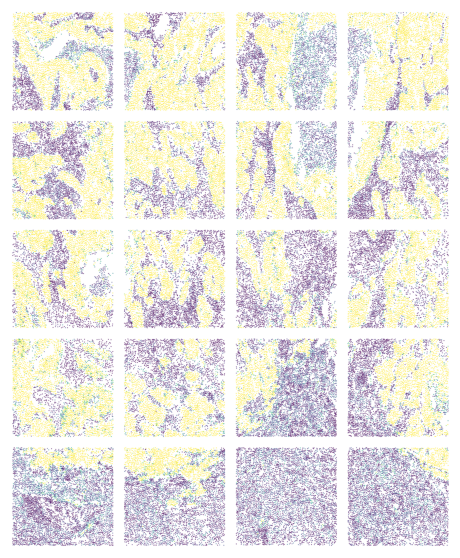

In [12]:
recon_img = cv2.imread('recon/recon_%s.png'%(marker))
recon_img = cv2.cvtColor(recon_img, cv2.COLOR_BGR2RGB)
figure = plt.figure(figsize=(10, 10))
plt.imshow(recon_img)
plt.axis('off')